In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

/home/mazor/nn/nn/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

batch_size = 32
# Transform to convert images to PyTorch tensors and normalize them
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data for MNIST
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


Using device: cuda


Size of training dataset: 60000


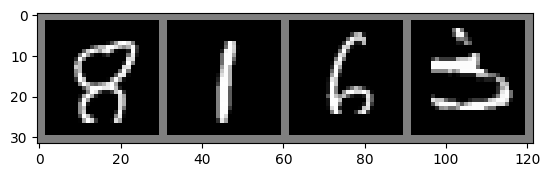

In [3]:
print("Size of training dataset:", len(trainset))
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(img.permute(1, 2, 0))  # convert from Tensor image

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images
imshow(torchvision.utils.make_grid(images[:4]))
plt.show()

# Check for empty data (unlikely in MNIST)
for i, (images, labels) in enumerate(trainloader):
    if torch.isnan(images).any() or torch.isnan(labels).any():
        print(f"Empty or corrupt data found at batch index: {i}")

In [4]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        # Define your layers here
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # Define the forward pass
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        

class ExplainableNetwork:
    def __init__(self, model):
        self.model = model
        self.activations_per_input = {}
        self.weights_per_layer = {}
        self.gradients_per_input = {} 
        self.current_epoch = 0
        self.num_epochs = 0
        self.batch_counter = 0

        self.expected_outputs = []
        self.predicted_outputs = []
        
        # Register hooks for each layer
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Linear):
                self.weights_per_layer[name] = None
                module.register_forward_hook(self.create_forward_hook(name))
                module.register_full_backward_hook(self.create_backward_hook(name))

    def create_forward_hook(self, layer_name):
        def forward_hook(module, input, output):
            # On the last epoch, store activations for each input
            if self.current_epoch == self.num_epochs - 1:
                self.store_activations(layer_name, output)
            # Always store the current weights
            self.weights_per_layer[layer_name] = module.weight.data.clone()
        return forward_hook

    def create_backward_hook(self, layer_name):
        def backward_hook(module, grad_input, grad_output):
            # Only store gradients on the last epoch
            if self.current_epoch == self.num_epochs - 1:
                # grad_output[0] contains the gradient with respect to the output of the layer
                self.store_gradients(layer_name, grad_output[0])
        return backward_hook


    def store_activations(self, layer_name, output):
        self._store_per_input(self.activations_per_input, layer_name, output)

    def store_gradients(self, layer_name, gradient):
        # Store gradients for the last epoch
        if self.current_epoch == self.num_epochs - 1:
            batch_size = gradient.size(0)
            for i in range(batch_size):
                input_index = self.batch_counter * batch_size + i
                if input_index not in self.gradients_per_input:
                    self.gradients_per_input[input_index] = {}
                self.gradients_per_input[input_index][layer_name] = gradient[i].detach().cpu().numpy()
    
            # Increment the backward batch counter only after processing the first layer (which is the last layer in the forward pass)


    def _store_per_input(self, storage_dict, layer_name, tensor):
        batch_size = tensor.size(0)
        for i in range(batch_size):
            input_index = self.batch_counter * batch_size + i
            if input_index not in storage_dict:
                storage_dict[input_index] = {}
            storage_dict[input_index][layer_name] = tensor[i].detach().cpu().numpy()

        if layer_name == list(self.model.named_modules())[-1][0]:
            self.batch_counter += 1

    def start_epoch(self, epoch, num_epochs):
        self.current_epoch = epoch
        self.num_epochs = num_epochs
        if epoch == num_epochs - 1:
            self.batch_counter = 0  # Reset the batch counter on the last epoch

    def get_activations(self, input_index):
        return self.activations_per_input.get(input_index, None)

    def get_gradients(self, input_index):
        return self.gradients_per_input.get(input_index, None)

    def print_structure(self):
        print("Explainable Network Structure and Data Summary:")

        # Check if there is any data collected
        if not self.activations_per_input:
            print("No activations data collected.")
            return

        if not self.gradients_per_input:
            print("No gradients data collected.")
            return

        # Print information about activations
        print("\nActivations:")
        first_input_activations = next(iter(self.activations_per_input.values()))
        for layer_name, activations in first_input_activations.items():
            num_nodes = len(activations)
            num_data_points = len(self.activations_per_input)
            print(f"Layer {layer_name}: {num_nodes} nodes, {num_data_points} data points each")

        # Print information about gradients
        print("\nGradients:")
        first_input_gradients = next(iter(self.gradients_per_input.values()))
        for layer_name, gradients in first_input_gradients.items():
            num_nodes = len(gradients)
            num_data_points = len(self.gradients_per_input)
            print(f"Layer {layer_name}: {num_nodes} nodes, {num_data_points} data points each")

    # TODO this uses the most recent weights
    def get_node_input(self, layer_name, node_index, image_index):
        if layer_name not in self.weights_per_layer:
            raise ValueError(f"Layer {layer_name} not found in the model")

        # Convert weights to numpy array
        weights = self.weights_per_layer[layer_name].cpu().numpy()

        if layer_name == 'fc1':
            # For the first layer, the input is the raw image data
            # Assuming you have a way to access the raw input images
            pass
        else:
            # For subsequent layers, we use activations from the previous layer
            prev_layer_name = self.get_previous_layer_name(layer_name)
            prev_activations = self.activations_per_input[image_index][prev_layer_name]

            # Ensure the prev_activations is a 1D array for proper dot product
            if prev_activations.ndim > 1:
                prev_activations = prev_activations.flatten()

            # Multiply previous layer's activations by the weights for the specific node
            input_to_node = np.dot(prev_activations, weights[node_index])

        return input_to_node

    def get_pre_sum_node_input(self, layer_name, node_index, image_index):
        if layer_name not in self.weights_per_layer:
            raise ValueError(f"Layer {layer_name} not found in the model")

        # Convert weights to numpy array
        weights = self.weights_per_layer[layer_name].cpu().numpy()

        if layer_name == 'fc1':
            # For the first layer, the input is the raw image data
            # Assuming you have a way to access the raw input images
            pass
        else:
            # For subsequent layers, we use activations from the previous layer
            prev_layer_name = self.get_previous_layer_name(layer_name)
            prev_activations = self.activations_per_input[image_index][prev_layer_name]

            # Ensure the prev_activations is a 1D array for proper multiplication
            if prev_activations.ndim > 1:
                prev_activations = prev_activations.flatten()

            # Multiply previous layer's activations by the weights for the specific node
            pre_sum_input_to_node = prev_activations * weights[node_index]

        return pre_sum_input_to_node
    
    def get_previous_layer_name(self, current_layer_name):
        # Helper function to get the previous layer's name
        layers = list(self.model.named_modules())
        for i, (name, _) in enumerate(layers):
            if name == current_layer_name:
                return layers[i - 1][0] if i > 0 else None

        return None

In [5]:
model = MNISTNet().to(device)
explainable_net = ExplainableNetwork(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2  # Adjust as needed

for epoch in range(num_epochs):
    explainable_net.start_epoch(epoch, num_epochs)
    model.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        if epoch == num_epochs - 1:
            explainable_net.expected_outputs.extend(targets.cpu().numpy())
            
            # Convert outputs to predicted class labels
            _, predicted = torch.max(outputs, 1)
            explainable_net.predicted_outputs.extend(predicted.cpu().numpy())
        


In [6]:
explainable_net.print_structure()

Explainable Network Structure and Data Summary:

Activations:
Layer fc1: 128 nodes, 60000 data points each
Layer fc2: 64 nodes, 60000 data points each
Layer fc3: 10 nodes, 60000 data points each

Gradients:
Layer fc3: 10 nodes, 60000 data points each
Layer fc2: 64 nodes, 60000 data points each
Layer fc1: 128 nodes, 60000 data points each


In [7]:
sample_size = 10

print(len(explainable_net.expected_outputs))
print(len(explainable_net.predicted_outputs))

print("Sample of Expected Outputs:", explainable_net.expected_outputs[:sample_size])
print("Sample of Predicted Outputs:", explainable_net.predicted_outputs[:sample_size])

60000
60000
Sample of Expected Outputs: [7, 3, 1, 8, 3, 3, 0, 7, 1, 7]
Sample of Predicted Outputs: [7, 3, 1, 8, 3, 3, 0, 7, 1, 7]


/tmp/ipykernel_93489/3435294759.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(activations, gradients, c=colors, cmap=color_map, s=15)  # Set dot size with `s`


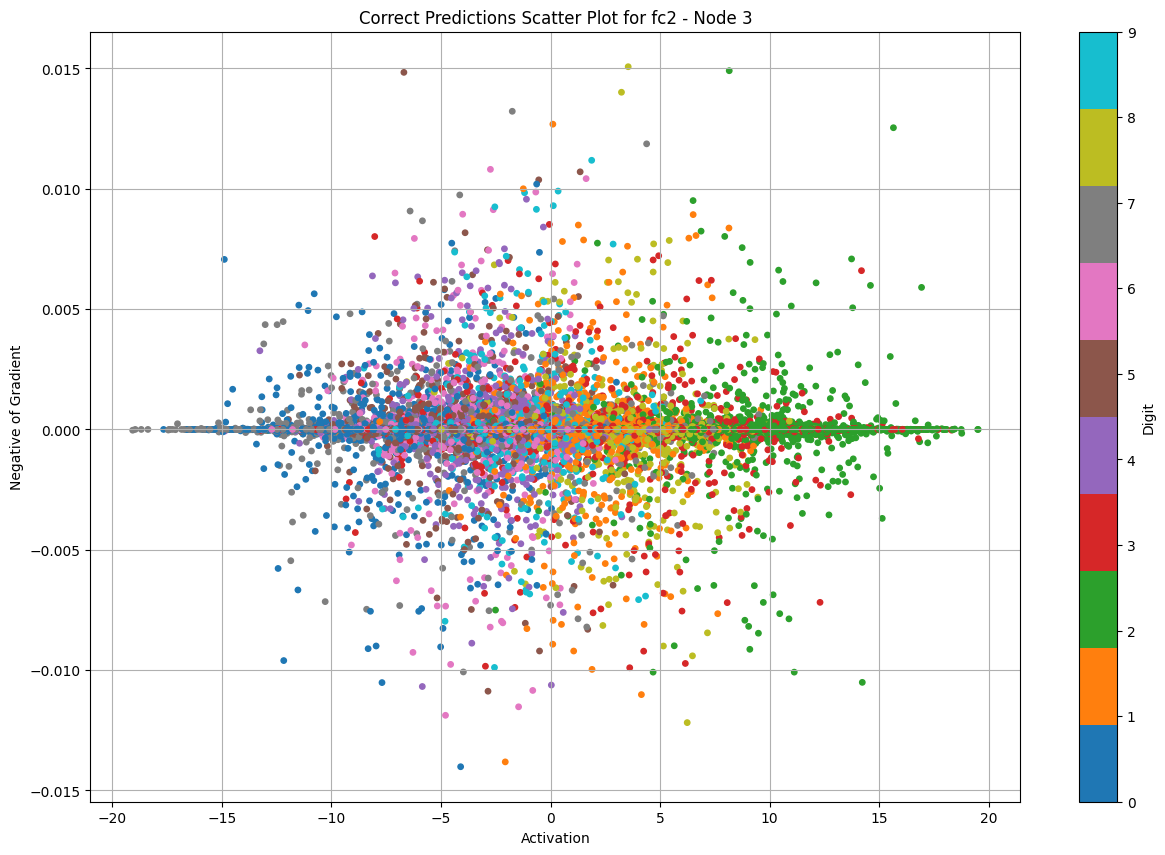

In [52]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

def plot_scatter_for_correct_predictions(explainable_network, layer_name, node_index):
    activations = []
    gradients = []
    colors = []

    # Define a color map for digits 0-9 using the new syntax
    color_map = matplotlib.colormaps['tab10']

    # Retrieve activations, gradients, and check for correct predictions
    for input_index, (expected, predicted) in enumerate(zip(explainable_network.expected_outputs, explainable_network.predicted_outputs)):
        if expected == predicted:
            activation = explainable_network.get_activations(input_index)
            gradient = explainable_network.get_gradients(input_index)

            if activation is not None and gradient is not None:
                activations.append(activation[layer_name][node_index])
                gradients.append(-gradient[layer_name][node_index])  # Negative of the gradient
                colors.append(color_map(expected))  # Color code based on the correct digit

    # Generate scatter plot
    fig, ax = plt.subplots(figsize=(15,10))  # Explicitly create figure and axes
    scatter = ax.scatter(activations, gradients, c=colors, cmap=color_map, s=15)  # Set dot size with `s`
    ax.set_xlabel('Activation')
    ax.set_ylabel('Negative of Gradient')
    ax.set_title(f'Correct Predictions Scatter Plot for {layer_name} - Node {node_index}')

    # Create a colorbar with the correct axes reference
    cbar = plt.colorbar(matplotlib.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(0, 9)), ax=ax, ticks=np.arange(0, 10))
    cbar.set_label('Digit')

    ax.grid(True)
    plt.show()

plot_scatter_for_correct_predictions(explainable_net, 'fc2', 3)  # Example for node 5 in the first hidden layer (fc1)



/tmp/ipykernel_93489/293118700.py:42: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(activations_extreme, gradients_extreme, c=colors_extreme, cmap=color_map, s=15)


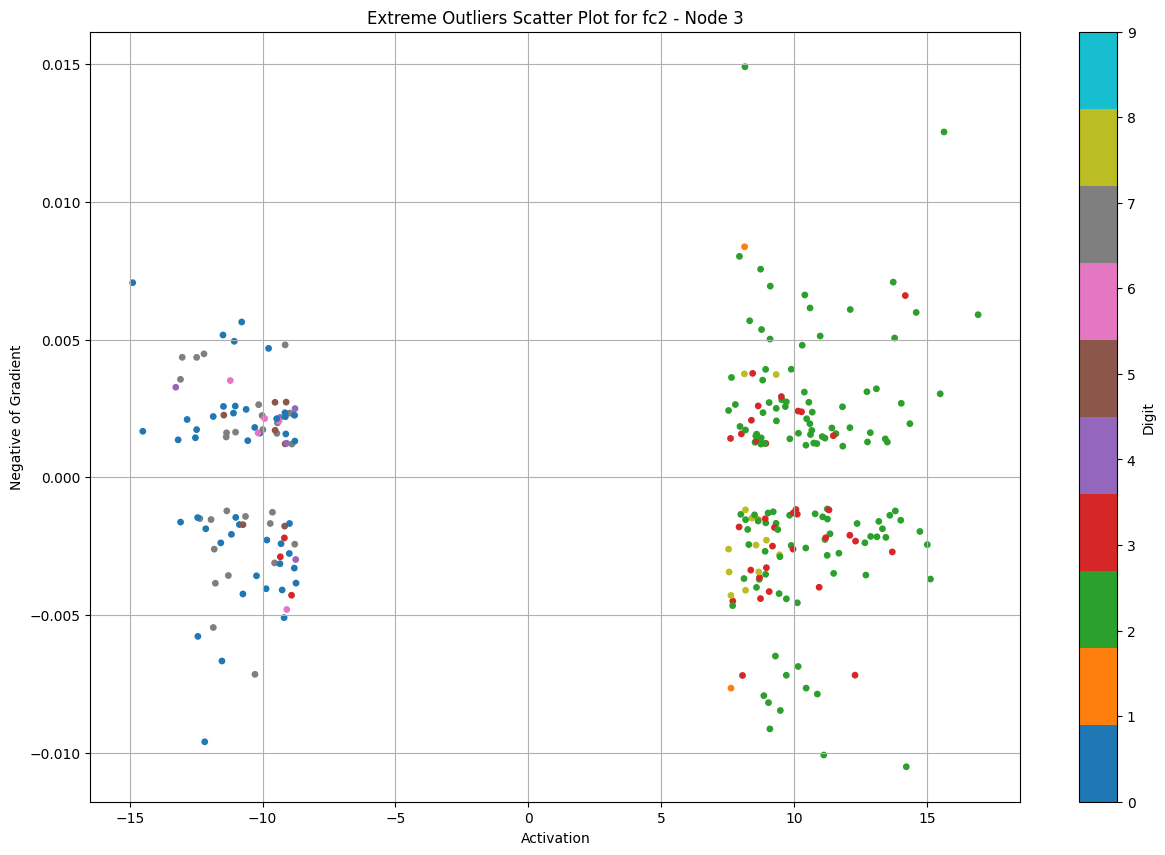

In [76]:
def plot_scatter_for_extreme_outliers(explainable_network, layer_name, node_index, std_dev_threshold=3):
    activations = []
    gradients = []
    colors = []

    # Define a color map for digits 0-9
    color_map = matplotlib.colormaps['tab10']

    # Retrieve activations, gradients, and check for correct predictions
    for input_index, (expected, predicted) in enumerate(zip(explainable_network.expected_outputs, explainable_network.predicted_outputs)):
        if expected == predicted:
            activation = explainable_network.get_activations(input_index)
            gradient = explainable_network.get_gradients(input_index)

            if activation is not None and gradient is not None:
                activations.append(activation[layer_name][node_index])
                gradients.append(-gradient[layer_name][node_index])  # Negative of the gradient
                colors.append(color_map(expected))  # Color code based on the correct digit

    # Convert lists to numpy arrays for numerical operations
    activations = np.array(activations)
    gradients = np.array(gradients)
    colors = np.array(colors)

    # Calculate mean and standard deviation for activations and gradients
    activation_mean = np.mean(activations)
    activation_std = np.std(activations)
    gradient_mean = np.mean(gradients)
    gradient_std = np.std(gradients)

    # Apply filtering for points that are more than std_dev_threshold away in both dimensions
    extreme_outliers = (np.abs(activations - activation_mean) > std_dev_threshold * activation_std) & \
                       (np.abs(gradients - gradient_mean) > std_dev_threshold * gradient_std)

    # Filter activations, gradients, and colors based on the extreme outlier condition
    activations_extreme = activations[extreme_outliers]
    gradients_extreme = gradients[extreme_outliers]
    colors_extreme = colors[extreme_outliers]

    # Generate scatter plot with extreme outliers
    fig, ax = plt.subplots(figsize=(15, 10))
    scatter = ax.scatter(activations_extreme, gradients_extreme, c=colors_extreme, cmap=color_map, s=15)
    ax.set_xlabel('Activation')
    ax.set_ylabel('Negative of Gradient')
    ax.set_title(f'Extreme Outliers Scatter Plot for {layer_name} - Node {node_index}')

    # Create a colorbar
    cbar = plt.colorbar(matplotlib.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(0, 9)), ax=ax, ticks=np.arange(0, 10))
    cbar.set_label('Digit')

    ax.grid(True)
    plt.show()

# Example usage:
plot_scatter_for_extreme_outliers(explainable_net, 'fc2', 3, std_dev_threshold=1.5)  # Adjust std_dev_threshold as needed


In [10]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the 10000 test images: {accuracy}%')


Accuracy of the model on the 10000 test images: 95.52%


In [25]:
# Corrected usage with image_index as an integer
image_index = 0  # Replace with the desired image index
target_layer = 'fc2'
target_node = 1  # Replace with the desired node index

input_to_node = explainable_net.get_node_input(target_layer, target_node, image_index)



In [26]:
print("Input to node {} in layer {} for image index {}:".format(target_node, target_layer, image_index))
print(input_to_node)



Input to node 1 in layer fc2 for image index 0:
2.5034323


In [27]:
pre_sum_input_to_node = explainable_net.get_pre_sum_node_input(target_layer, target_node, image_index)

# Print the result
print(f"Pre-sum weighted inputs to node {target_node} in layer {target_layer} for image index {image_index}:")
print(pre_sum_input_to_node)

Pre-sum weighted inputs to node 1 in layer fc2 for image index 0:
[-0.29656386 -0.06276906  0.26755106 -0.20717134  0.03256038 -0.22800708
  0.18390618 -0.46569383  0.24249855  0.23393373  0.02382702  0.2957812
 -0.5668702   0.01085092 -1.1509138   0.03187189  0.0084413  -0.03122485
  0.16456707  0.59108186 -0.1317034   0.01999639  0.77431965  0.00626626
 -0.07618476 -0.08799518  0.08716518  0.17433819 -0.14242277  0.10333649
  0.2232453  -0.63437074 -0.02451439  0.00181988  0.230086   -0.10375826
  0.13412917  0.1100162  -1.0762336   0.00407204  0.28315568  0.01477323
 -0.06807325  0.02070625  0.17117393 -0.2823142  -0.0117013   0.18041576
  0.22511661  0.00710988  0.12153124 -0.21195649 -0.28677604  0.2764036
  0.24352486 -0.12208672 -0.00688657  0.21008511 -0.35538846 -0.13378814
 -0.12325048 -0.20833233  0.04442778  0.29521078 -0.28984913  0.29898882
  0.10059261  0.8098461   0.14483972  0.00962134  0.12030158  0.3350545
  0.87869567  0.0193641   0.03408234  0.14413024 -0.12707022 

In [28]:
def print_activation_for_node(explainable_net, image_index, layer_name, node_index):
    # Check if the requested image index is in the stored activations
    if image_index in explainable_net.activations_per_input:
        image_activations = explainable_net.activations_per_input[image_index]
        
        # Check if the requested layer is in the activations for the image index
        if layer_name in image_activations:
            # Check if the requested node index is within the range of the layer's activations
            if node_index < len(image_activations[layer_name]):
                # Retrieve the specific activation for the node
                activation = image_activations[layer_name][node_index]
                print(f"Activation for image index {image_index}, layer '{layer_name}', node {node_index}: {activation}")
            else:
                print(f"Node index {node_index} is out of range for layer '{layer_name}'.")
        else:
            print(f"Layer '{layer_name}' not found for image index {image_index}. Available layers are: {list(image_activations.keys())}")
    else:
        print(f"No activation information for image index {image_index}. Available image indices are: {list(explainable_net.activations_per_input.keys())}")

# Example usage:
print_activation_for_node(explainable_net, image_index=0, layer_name='fc1', node_index=1)


Activation for image index 0, layer 'fc1', node 1: -0.7817296981811523


In [36]:
def print_activation_and_weights(explainable_net, layer_name, node_index, image_index):
    # Check if the layer is in the model
    if layer_name not in explainable_net.weights_per_layer:
        raise ValueError(f"Layer {layer_name} not found in the model")

    # Convert weights to numpy array
    weights = explainable_net.weights_per_layer[layer_name].cpu().numpy()

    # Retrieve the activations for the previous layer
    if layer_name == 'fc1':
        # For the first layer, we don't have previous layer activations
        # Assuming you have a way to access the raw input images
        print("Layer 'fc1' does not have previous layer activations.")
    else:
        # For subsequent layers, we use activations from the previous layer
        prev_layer_name = explainable_net.get_previous_layer_name(layer_name)
        prev_activations = explainable_net.activations_per_input[image_index][prev_layer_name]

        # Ensure the prev_activations is a 1D array for proper printing
        if prev_activations.ndim > 1:
            prev_activations = prev_activations.flatten()

        # Get the weights for the specific node
        node_weights = weights[node_index]

        # Print the activations and weights
        print(f"Activations from previous layer '{prev_layer_name}' for image index {image_index}: {prev_activations}")
        print(f"Weights for node {node_index} in layer '{layer_name}': {node_weights}")

# Example usage:
print_activation_and_weights(explainable_net, layer_name='fc3', node_index=2, image_index=1)


Activations from previous layer 'fc2' for image index 1: [-3.9116101e+00 -6.2598581e+00 -5.2289972e+00  5.6823535e+00
 -4.4925213e-02 -6.4408598e+00  3.6114800e-01  1.2127520e+01
 -2.2846532e+00 -6.5158396e+00  8.5910072e+00  7.2667348e-01
 -6.0263853e+00 -6.0030241e+00  5.9551597e+00 -4.8783569e+00
 -6.0248122e+00  5.8097591e+00  3.1596909e+00  8.4253044e+00
  9.3594847e+00 -3.9356446e+00 -7.9808700e-01  1.2327472e+00
  4.4996090e+00 -3.1316602e+00 -4.7660098e+00  1.3955208e+00
 -9.4981730e-02 -9.3709421e-01 -5.9095173e+00 -3.4964242e+00
  3.8495939e+00 -3.0399401e+00  3.3711245e+00  1.8440659e+00
 -3.1554790e+00 -3.6714008e+00 -4.0939770e+00 -2.9417717e+00
  1.7418619e+00 -1.6482180e+00  7.9308395e+00 -8.0501070e+00
 -6.1702433e+00  7.6257782e+00 -4.3497605e+00  2.6811883e+00
  1.0371595e+01 -5.2062483e+00  4.7685423e+00  4.0431967e+00
  8.9134541e+00 -8.5452642e+00  1.2086868e-01 -5.8277903e+00
 -8.4772110e-03  5.6612225e+00 -2.4023526e+00 -8.9287310e+00
 -5.0727010e-01 -3.6756823e+